In [2]:
from PIL import Image  
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [4]:
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [6]:
!ls 'gdrive/My Drive/Neural_style_transfer'

ari.jpg  Go.jpg  Neural_style_transfer.ipynb  Oisik.jpg  pablo.jpg


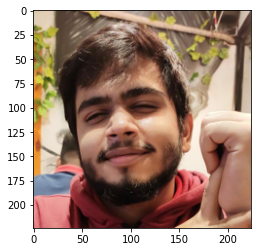

In [7]:
im = Image.open(r"gdrive/My Drive/Neural_style_transfer/ari.jpg") 
newsize = (224, 224) 
im = im.resize(newsize) 
im = np.array(im, dtype = np.float32)/255.0
plt.imshow(im)
im = tf.constant(im)

Our Content Image

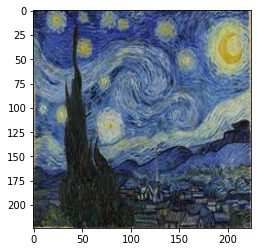

In [8]:
im_2 = Image.open(r"gdrive/My Drive/Neural_style_transfer/Go.jpg") 
newsize = (224, 224) 
im_2 = im_2.resize(newsize)
im_2 = np.array(im_2, dtype = np.float32)/255.0
plt.imshow(im_2)
im_2 = tf.constant(im_2)

Our Style Image

In [9]:
im.shape

TensorShape([224, 224, 3])

In [10]:
from tensorflow.keras.applications.vgg19 import VGG19

## We are using a pre-trained VGG-19 model for our purpose. Note that the weights have not been Normalized**

In [11]:
model = VGG19()
print(model.summary())

574717952/574710816 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

# OUR WHITE NOISE DUMMY IMAGE IS CREATED

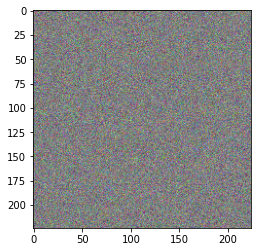

In [12]:
z = np.random.normal(size = (224,224,3), loc = 0.5, scale = 0.1)
#z = np.array(Z)/255.0
plt.imshow(z)


In [13]:
z.shape

(224, 224, 3)

## The Content loss

In [14]:
def compute_content_cost(a_C, a_G):
    m, n_h, n_w, n_c = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_h * n_w, n_c]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_h * n_w, n_c]) 
    #unrolled here means reshaping the tensors in a height and width combined spatial format
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4 * n_h * n_w * n_c)
    
    
    return J_content

The content loss function takes in two tensors as its parameters. a_C is a tensor which represents the output of our chosen content layer when our content Image is passed through it. Similarly, a_G represents the output of our chosen content layer when our generated image is passed through it

# ** Style Transfer**

In [15]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))

    return GA

The gram matrix finds out correlation of tensors with itself

In [16]:
sdef compute_layer_style_cost(a_S, a_G):
   
    m, n_h, n_w, n_c = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, [n_h*n_w, n_c])
    a_G = tf.reshape(a_G, [n_h*n_w, n_c])

    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    
    J_style_layer = tf.reduce_sum(tf.square(GS-GG))/(4 * n_c**2 * (n_w*n_h)**2)
    
    
    return J_style_layer

The gram matrix procured from the style image and the generated image is then used to define the style loss. 

In [19]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [20]:
def compute_style_cost(model, STYLE_LAYERS,image):
    
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        #We create intermediate models for each layer present in the style list for our style cost. 
        
        layer_output=model.get_layer(layer_name).output
 
        intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)

        intermediate_prediction = intermediate_model(tf.expand_dims(im_2, 0))
        
        

        out = tf.convert_to_tensor(intermediate_prediction)

    
        a_S = out
        
        
        

        intermediate_prediction = intermediate_model(tf.expand_dims(image, 0))
        
        out = tf.convert_to_tensor(intermediate_prediction)
        
    
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

Unlike our content loss, where we need only the high level interpretations of the image to create a similar copy of it,  the style loss only focuses on the texture, and it has been proven that taking a average loss from a series of layers and by assigning weights to theses layers (style weights) to signify their contribution to our final loss helps in completing the objection i.e not taking any kind of complex feature from our style image (like humans and buildings) but instead just taking just the texture


In [21]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
  
    J = alpha * J_content + beta * J_style
  
    
    return J

This function returns our total loss (J_style + J_content)

In [22]:
#TESTING LAYER WISE OUTPUTS


layer_output=model.get_layer('block4_conv2').output 
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction = intermediate_model(tf.expand_dims(im, 0))
a_C = tf.convert_to_tensor(intermediate_prediction)



intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction = intermediate_model(tf.expand_dims(z, 0))
a_G = tf.convert_to_tensor(intermediate_prediction)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

Here we just test our functions to see if they are error proof. 

In [23]:
J_style = compute_style_cost(model, STYLE_LAYERS,z)
J = total_cost(J_content, J_style, alpha=10, beta=40)
J,J_style, J_content

(<tf.Tensor: shape=(), dtype=float32, numpy=37766.723>,
 <tf.Tensor: shape=(), dtype=float32, numpy=933.31616>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43.407482>)

In [24]:
tf.keras.backend.clear_session()

# **Our Primary fuction for extraction of our content inputs and style inputs**

In [25]:
def extract(img):
    
    # we create an intermediate model since we need the output of a certain particular layer for our content loss. 
    layer_output=model.get_layer('block4_conv2').output
    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)


    intermediate_prediction = intermediate_model(tf.expand_dims(im, 0)) 
    a_C = tf.convert_to_tensor(intermediate_prediction)
        


    
    intermediate_prediction = intermediate_model(tf.expand_dims(img, 0))
    a_G = tf.convert_to_tensor(intermediate_prediction)
    
    J_content = compute_content_cost(a_C, a_G)
    J_style = compute_style_cost(model, STYLE_LAYERS,img)
    
    return [J_content, J_style] 

In [26]:
def loss(output):
  #creating a simpler total loss function which takes in a list
    return 10*output[0] + 40*output[1]

In [27]:
def train_step(image):
    
    
    with tf.GradientTape() as tape:
        
        outputs = extract(image)
        
        total_loss = loss(outputs)
        
      # Determine the gradients of the loss function w.r.t the image pixels
     
    grad = tape.gradient(total_loss, [image])
      # Update the pixels
    
    
    opt.apply_gradients(zip(grad, [image]))
    # Clip the pixel values that fall outside the range of [0,1]
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
    

In [41]:
epochs = 6000
z = tf.Variable(z)

# **The Training step**

In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
gif_list = []
for i in tqdm(range(epochs)):
    train_step(z)
    if i % 50 == 0:
      gif_list.append(z.numpy())
    

100%|██████████| 6000/6000 [55:17<00:00,  1.81it/s]


### OUr training is complete, now we shall represent our output in the form of a Gif, to see the white noise dummy image turning into our desired output

In [44]:
for i in range(len(gif_list)):
  fig = plt.figure(figsize=(10,10))
  plt.imshow(gif_list[i])
  plt.savefig('image_at_epoch_{:04d}.png'.format(i))
  

Output hidden; open in https://colab.research.google.com to view.

In [45]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [46]:
!pip install -q imageio

In [47]:
import glob
import imageio
from IPython import display

In [51]:
!pip install -q git+https://github.com/tensorflow/docs

In [48]:
anim_file = 'aritra_star.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [52]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## **A final Wrap up of our whole work**

Our Gif is complete. 

Text(0.5, 1.0, 'Generated Image')

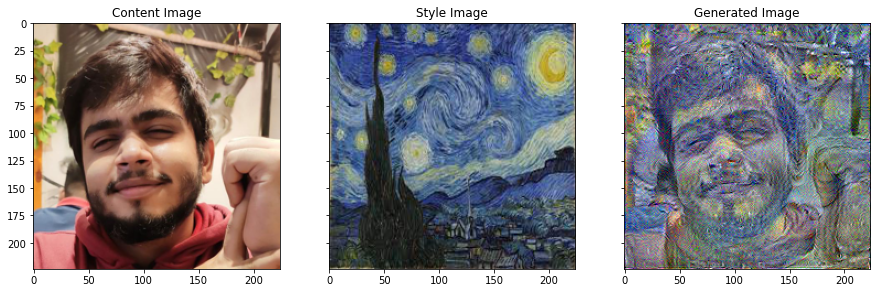

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(15)
f.set_figwidth(15)
ax1.imshow(im.numpy())
ax1.set_title('Content Image')
ax2.imshow(im_2.numpy())
ax2.set_title('Style Image')
ax3.imshow(z.numpy())
ax3.set_title('Generated Image')
